## Import Packages

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import umap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import glob
import os
from learner import Learner
from mpl_toolkits.mplot3d import Axes3D

import pickle

# from advertorch.attacks import LinfPGDAttack
%matplotlib inline

device = torch.device("cuda:0")

c:\Users\Suhwan\AppData\Local\anaconda3\envs\ADV\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Suhwan\AppData\Local\anaconda3\envs\ADV\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Suhwan\AppData\Local\anaconda3\envs\ADV\Lib\site-packag

## Load Model

In [163]:
model = torch.load("../model/resnet50_5way_112_.pt")
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Add Hook

In [164]:
def hook_fn(module, input, output):
    module.output = output

def addHook(model, hook):
    for layer in model.children():
        if len(list(layer.children())) > 0: # if module has children -> sequential
            addHook(layer, hook)

        else:
            layer.register_forward_hook(hook)

def collectOutput(model, output_list):
    for layer in model.children():
        if len(list(layer.children())) > 0: # if module has children -> sequential
            collectOutput(layer, output_list)
        
        elif type(layer) == nn.ParameterList:
            return

        else:
            output = layer.output
            output_list.append(output)

def getName(model, name_list):
    for layer in model.children():
        if len(list(layer.children())) > 0: # if module has children -> sequential
            getName(layer, name_list)

        else:
            layer_name = str(layer)[:str(layer).index("(")] + str(len(list(filter(lambda x:str(layer)[:str(layer).index("(")] in x, name_list))))
            name_list.append(layer_name)


addHook(model, hook_fn)

## Load Data

In [3]:
PATH = "eps_6.0"
image_paths = glob.glob(f"../{PATH}/*", )
image_names = [os.path.basename(i) for i in image_paths]

print(image_paths)

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0, 0, 0,), std=(1, 1, 1))
])

def loadImage(path, is_pickle = False):

    if is_pickle:
        with open(path, "rb") as f:
            image = pickle.load(f)

    else:
        image = Image.open(path)
        image = transform(image).to(device).unsqueeze(0)

    return image

    

[]


## Inference && Get output

In [166]:
errorses = []
vectors = []
labels = []
names = []

getName(model, names)
# names = names[:-1] # for excepting linear

with torch.no_grad():
    model.eval()
    for i in range(len(image_paths) // 2):
        attack_output_list = []
        origin_output_list = []
        outputs = []

        x = loadImage(image_paths[2 * i], is_pickle=True).unsqueeze(0)

        # x += 0.01

        model(x)

        collectOutput(model, attack_output_list)

        x2 = loadImage(image_paths[2 * i + 1], is_pickle=True).unsqueeze(0)

        model(x2)

        collectOutput(model, origin_output_list)

        errors = [torch.abs(attack_feature_map - origin_feature_map).cpu() for attack_feature_map, origin_feature_map in zip(attack_output_list, origin_output_list)]
        errorses.append(errors[:])

        attack_feature = attack_output_list[-2]
        origin_feature = origin_output_list[-2]

        # print(attack_feature)
        # print(origin_feature)

        vectors.append(attack_feature.view(-1))
        vectors.append(origin_feature.view(-1))

        labels.append(int(image_names[2 * i].split("_")[-1][:-7]))
        labels.append(-1*int(image_names[2 * i + 1].split("_")[-1][:-7]))

        for attack_output, origin_output, error in zip(attack_output_list, origin_output_list, errors):
            outputs.append(attack_output)
            outputs.append(origin_output)
            outputs.append(error)


        

        

## Make Feature Map

192


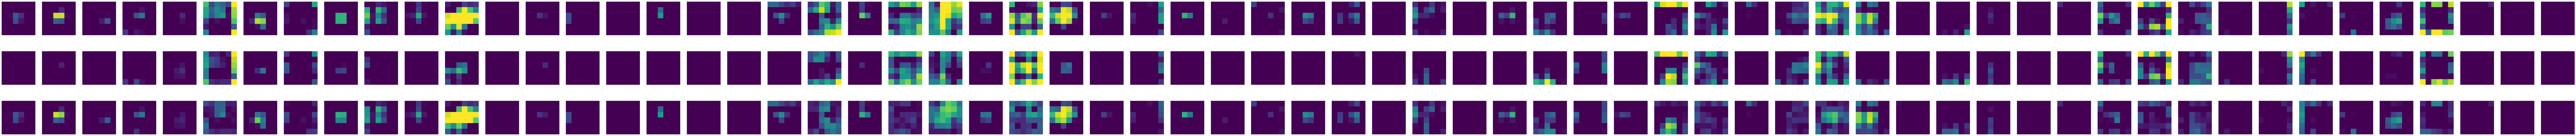

In [125]:
LAYER = 10
FEATURE_MAP_NUM = 64

processed = []
for feature_map in outputs[LAYER * 3:(LAYER + 1) * 3]:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    for features in feature_map[:FEATURE_MAP_NUM]:
        processed.append(features.data.cpu().numpy())
    # processed.append(gray_scale.data.cpu().numpy())
# fig = plt.figure(figsize=(11, 500))

fig = plt.figure(figsize=(200, 11))


print(len(processed))
for i in range(len(processed)):
    a = fig.add_subplot(3, FEATURE_MAP_NUM, i+1)
    imgplot = plt.imshow(processed[i], vmin=0, vmax=1)
    a.axis("off")
    # a.set_title(f"{names[i//3]}_{i//3}", fontsize=10)
plt.savefig(f'feature_maps_{PATH}_conv_{LAYER}.jpg', bbox_inches='tight')

## Make Error Graph

In [167]:
print(len(errorses))
mean_errorses = []

for errors in errorses:
    mean_errors = []
    for error in errors:
        if len(error.shape) == 4:
            _, c, h, w = error.shape
            pixel_num = c * h * w
            sum_shape = (1, 2, 3)
        
        elif len(error.shape) == 2:
            a, b = error.shape
            pixel_num = a * b
            sum_shape = (1)

        error_sum = torch.sum(error, sum_shape)
        error_mean = torch.abs((error_sum / pixel_num)).item()
        
        mean_errors.append(error_mean)
        # print(error.shape)
        print(error_mean)

    mean_errorses.append(mean_errors)

    print()



245
0.00599420303478837
0.007638802286237478
0.007638802286237478
0.010992474853992462
0.008963864296674728
0.008048858493566513
0.015601963736116886
0.009374371729791164
0.00461857533082366
0.013070940040051937
0.013070940040051937
0.00750237051397562
0.01585765928030014
0.023441562429070473
0.012034769169986248
0.019514475017786026
0.01845925860106945
0.0064164563082158566
0.020577428862452507
0.020577428862452507
0.02873893640935421
0.013796273618936539
0.028148850426077843
0.022520041093230247
0.006949194706976414
0.028451044112443924
0.028451044112443924
0.040311090648174286
0.015465994365513325
0.035645872354507446
0.025114957243204117
0.01142344530671835
0.020154796540737152
0.020154796540737152
0.01752827689051628
0.017978571355342865
0.018577154725790024
0.008078103885054588
0.0158339012414217
0.009286662563681602
0.0038222207222133875
0.022672375664114952
0.022672375664114952
0.030837368220090866
0.015483513474464417
0.028307979926466942
0.01828913949429989
0.0086129903793334

In [168]:
mean_errorses_tensor = torch.tensor(mean_errorses)

mean_errorses_mean = torch.mean(mean_errorses_tensor, dim=0)

print(mean_errorses_mean.shape)

torch.Size([126])


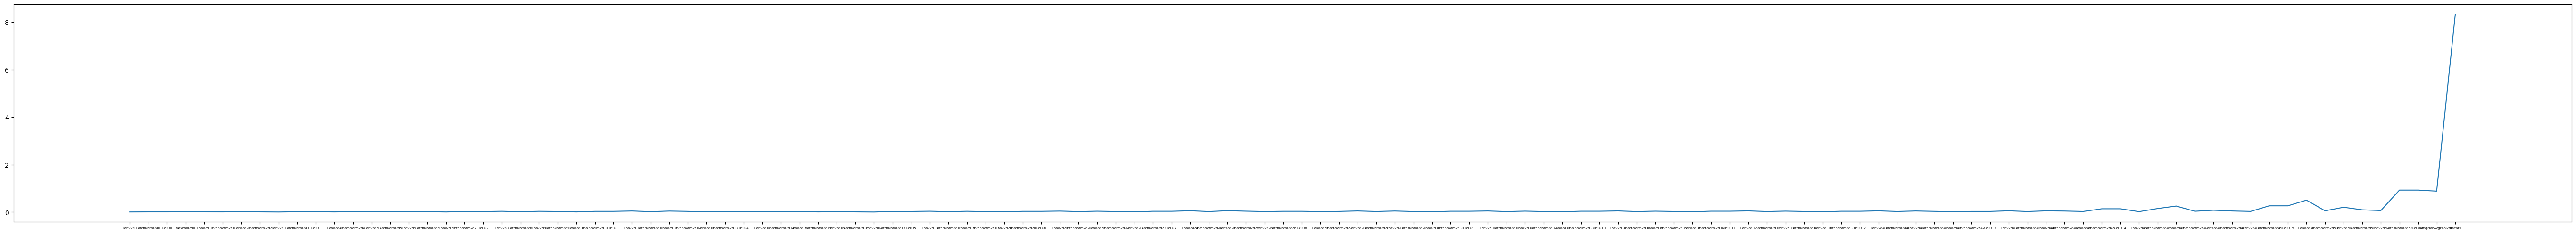

In [169]:
plt.figure(figsize=(70, 6))  # Width: 10 inches, Height: 6 inches

# Create the plot
plt.plot(names[:], mean_errorses_mean)
plt.xticks(fontsize=5)

# plt.ylim(0, 0.31)

plt.savefig('error_res_res_deepfool.png')

## Make UMAP Visualization

In [170]:
features = torch.stack(vectors).cpu()

print(features.shape)

torch.Size([490, 2048])


In [171]:
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.5, metric="cosine", random_state=50)

embedding = reducer.fit_transform(features)
print(embedding.shape)

(490, 2)


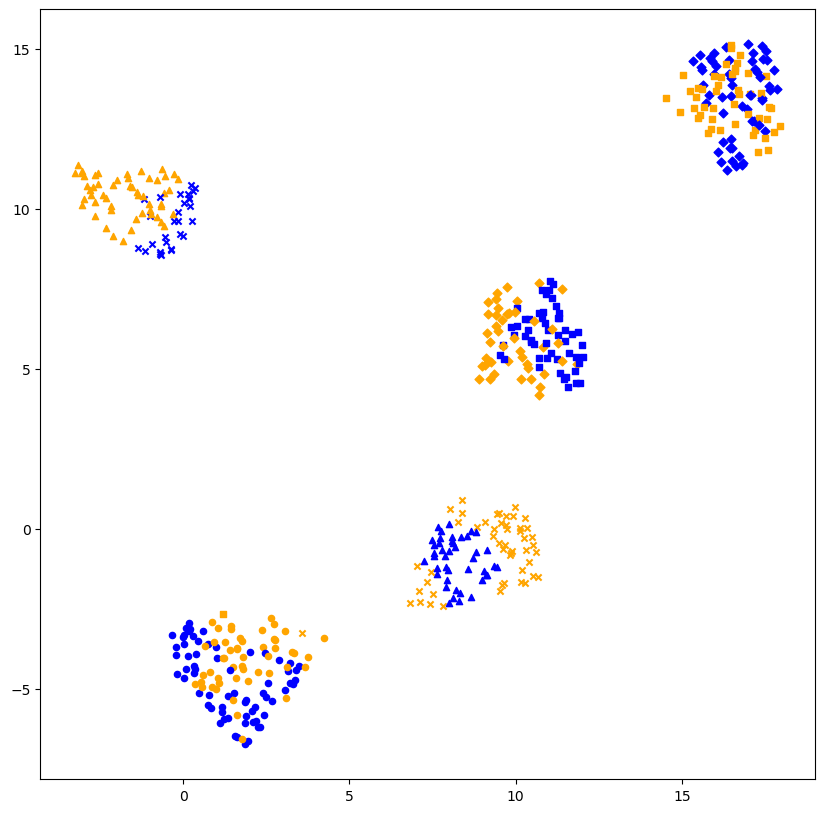

In [175]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'x', 'D']

fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# 3D axes를 만들기 위해 projection=’3d’ 키워드를 입력해줍니다.

for i in range(embedding.shape[0]//2):
    # print(labels[i])

    plt.scatter(embedding[2 * i, 0], embedding[2 * i, 1], label=abs(labels[2 * i]), marker=markers[labels[2 * i]], color="blue", s=20) # attack
    plt.scatter(embedding[2 * i + 1, 0], embedding[2 * i + 1, 1], label=abs(labels[2 * i + 1]), marker=markers[labels[2 * i + 1]], color="orange", s=20) # origin
    
plt.savefig('diff_6.0.png')
